# Import modules

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from dateutil.parser import parse
import matplotlib.pyplot as plt
import seaborn as sns
import json
import boto3
import io
from pytz import timezone
from scipy import signal
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline 

from models import *

# Set up S3 connection

In [2]:
conn = boto3.client('s3')
s3 = boto3.resource('s3')
bucketname = 'aads-tagyourmeal'
sample_rate = 50
INDY = "America/Indiana/Indianapolis"
baseline_date = parse('2019-01-01 00:00:00 +0000')

# Catalog the Contents

It generate 3 dataframe contains detailed information. 

!! This works fine when data is not huge, evently, this function will move to Lambda and catalog will be saved in a database

In [3]:
catalog = get_mealtag_catalog(bucketname)
catalog["motion"]

,user,secelapsed,date,time,timezone,minutes,path
0,02ce,6894406.0,2019-03-21,19:06:46,+0000,0,s3://aads-tagyourmeal/02ce_motion_2019-03-21 1...
1,03f9,6895098.0,2019-03-21,19:18:18,+0000,0,s3://aads-tagyourmeal/03f9_motion_2019-03-21 1...
2,03f9,6920785.0,2019-03-22,02:26:25,+0000,0,s3://aads-tagyourmeal/03f9_motion_2019-03-22 0...
3,03f9,6920879.0,2019-03-22,02:27:59,+0000,1,s3://aads-tagyourmeal/03f9_motion_2019-03-22 0...
4,alpha,5060553.0,2019-02-28,13:42:33,+0000,141,s3://aads-tagyourmeal/alpha_motiondata_2019-02...
5,alpha,5148221.0,2019-03-01,14:03:41,+0000,618,s3://aads-tagyourmeal/alpha_motiondata_2019-03...
6,jieshen,6444106.0,2019-03-16,14:01:46,+0000,631,s3://aads-tagyourmeal/jieshen_motion_2019-03-1...
7,jieshen,6481927.0,2019-03-17,00:32:07,+0000,14,s3://aads-tagyourmeal/jieshen_motion_2019-03-1...
8,lldb,5922265.0,2019-03-10,13:04:25,+0000,690,s3://aads-tagyourmeal/lldb_motion_2019-03-10 1...
9,lldb,6010664.0,2019-03-11,13:37:44,+0000,656,s3://aads-tagyourmeal/lldb_motion_2019-03-11 1...


# Summarize the results 

In [4]:
summarize_motion(catalog["motion"],"2019-03-10")


'{"no_user": 4, "total_session": 8, "total_min": 1992, "ave_min": 249.0}'

# Plot some data

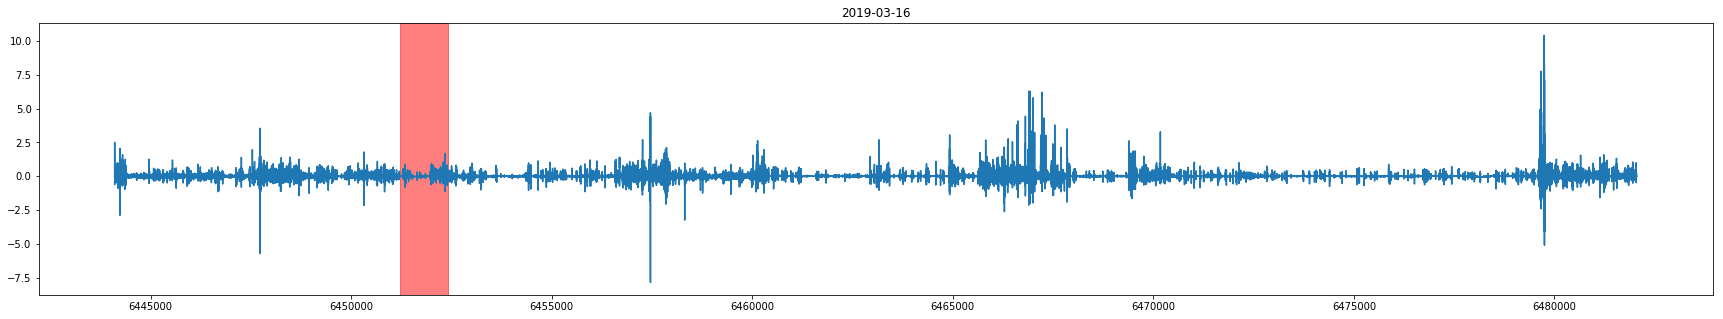

In [5]:
df_list = day_gram("jieshen",["accl_x"], catalog, ['2019-03-16'])

# First 100s Power Density of Mean Accelerometer

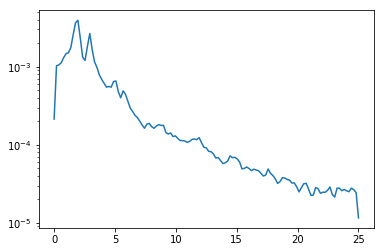

In [6]:
f, Pxx_den = signal.welch(df_list[0]["accl_x"],sample_rate)
plt.semilogy(f, Pxx_den)


# Feature Engineering, using Welch's method to estimate the power spectural density

In [21]:
windowsize=60

features = []
tags = []
for i in range(len(df_list[0]) // (sample_rate * windowsize)):
    chunk = df_list[0].iloc[i*(sample_rate * windowsize):(i+1)*(sample_rate * windowsize),:]
    _, Pxx_den_x = signal.welch(chunk["accl_x"],sample_rate)
    _, Pxx_den_y = signal.welch(chunk["accl_y"],sample_rate)
    _, Pxx_den_z = signal.welch(chunk["accl_z"],sample_rate)
    feature = np.append(Pxx_den_x,Pxx_den_y)
    feature = np.append(feature, Pxx_den_z)
    features.append(feature)
    tags.append(chunk['tag'].median())
# print(len(features))

In [22]:
X=np.asarray(features)
y=np.asarray(tags)
print(X.shape)
print(y.shape)

(632, 387)
(632,)


# Visulization of the features
## PCA



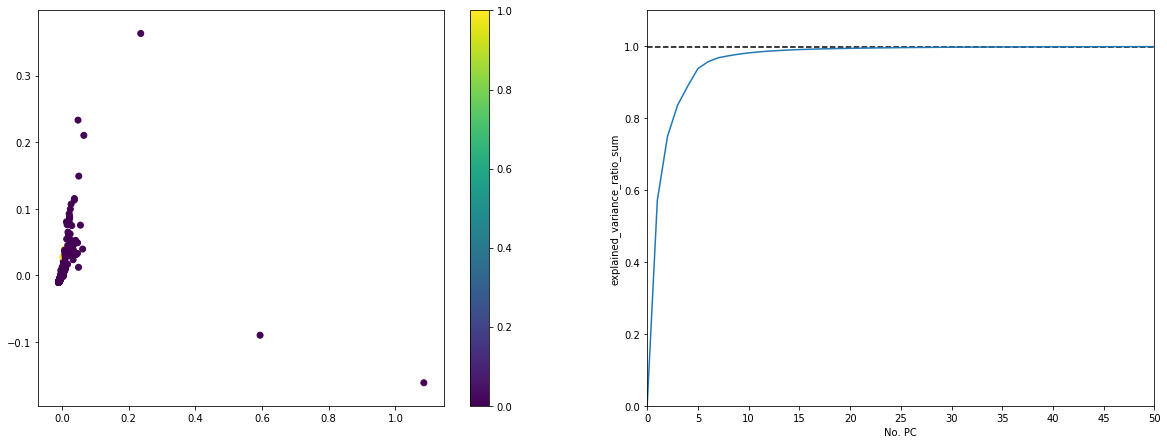

In [33]:
def plot_pca(X, y, nc=100):

    pca = PCA(n_components=nc)
    principalComponents = pca.fit_transform(X)

    principalDf = pd.DataFrame(data = principalComponents[:,0:2], columns = ['principal component 1', 'principal component 2'])
    finalDF = pd.concat([principalDf, pd.DataFrame(tags)], axis = 1)
    fig = plt.figure(figsize=(20,16))
    fig.add_axes()
    ax1 = fig.add_subplot(221)
    sc = plt.scatter(x="PC1",
                     y="PC2",
                     data=pd.DataFrame(data = principalComponents[:,0:2], columns = ['PC1', 'PC2']),
                     c=tags,
                     cmap='viridis')
    plt.colorbar(sc)

    
    pcaratio=pca.explained_variance_ratio_
    s = 0
    s_list=[0]
    for r in pcaratio:
        s+=r
        s_list.append(s)

    ax2 = fig.add_subplot(222)
    ax2.plot(s_list)
    ax2.hlines(s_list[-1],0,nc,linestyles='dashed')
    ax2.axis([0,nc,0,1.1])
    plt.xticks(np.arange(0,nc+1,step=5))
    plt.ylabel('explained_variance_ratio_sum')
    plt.xlabel('No. PC')
    plt.show()
    
    return principalComponents


principalComponents = plot_pca(X,y,nc=50)


## Using t-SNE

[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 632 samples in 0.004s...
[t-SNE] Computed neighbors for 632 samples in 0.191s...
[t-SNE] Computed conditional probabilities for sample 632 / 632
[t-SNE] Mean sigma: 0.000034
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.778133
[t-SNE] Error after 1000 iterations: 0.621941


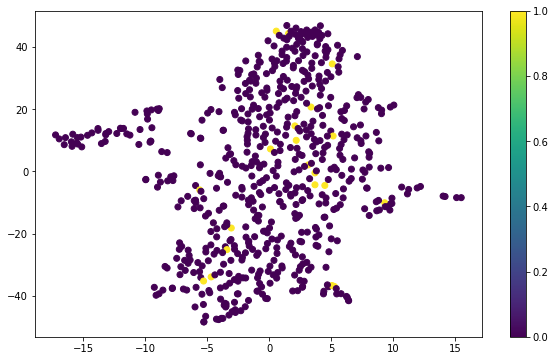

In [30]:
from sklearn.manifold import TSNE
lr = 10
pp = 5

def plot_tsne(X, y, lr=10, pp=5):
    X_tsne = TSNE(learning_rate=lr,
                  n_components=2, 
                  perplexity=pp, 
                  verbose=1, 
                  n_iter=1000).fit_transform(X)

    fig = plt.figure(figsize=(10,6))
#     fig.set(title="t-SNE on PCA")
    sc = plt.scatter(x="PC1",
                     y="PC2",
                     data=pd.DataFrame(data = X_tsne[:,0:2], columns = ['PC1', 'PC2']),
                     c=tags,
                     cmap='viridis')
    plt.colorbar(sc)


plot_tsne(X,y, 10, 25)

In [ ]:
!git add sensor_data_lookup.ipynb
!git commit -m "add sensor data"

In [ ]:
!git push

In [ ]:
from sklearn.manifold import TSNE
lr = 10
pp = 5

def plot_tsne(X, y, lr=10, pp=5):
    X_tsne_pca = TSNE(learning_rate=lr,
                      n_components=2, 
                      perplexity=pp, 
                      verbose=1, 
                      n_iter=1000).fit_transform(principalComponents)

    X_tsne = TSNE(learning_rate=lr,
                  n_components=2, 
                  perplexity=pp, 
                  verbose=1, 
                  n_iter=1000).fit_transform(X)

    fig = plt.figure(figsize=(10,6))
    fig.add_axes()
    ax1 = fig.add_subplot(221)
    ax1.set(title="t-SNE on PCA")
    sc = plt.scatter(x="PC1",
                     y="PC2",
                     data=pd.DataFrame(data = X_tsne_pca[:,0:2], columns = ['PC1', 'PC2']),
                     c=tags,
                     cmap='viridis')
    plt.colorbar(sc)

    ax2 = fig.add_subplot(222)
    ax2.set(title="t-SNE on X")
    sc = plt.scatter(x="PC1",
                     y="PC2",
                     data=pd.DataFrame(data = X_tsne[:,0:2], columns = ['PC1', 'PC2']),
                     c=tags,
                     cmap='viridis')
    plt.colorbar(sc)